In [1]:
import warnings
from typing import Tuple, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve

## Загрузка данных

In [2]:
data = pd.read_csv("data.csv")
print("data.shape = {} rows, {} cols".format(*data.shape))
data.head(n=2)

data.shape = 100000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df1 = data[['TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']]

In [4]:
df2 = data["isFraud"]

In [5]:
x_train, x_valid = train_test_split(
    df1, train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    df2, train_size=0.7, shuffle=True, random_state=1,
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 70000 rows, 17 cols
x_valid.shape = 30000 rows, 17 cols


## Ранее рассмотренные модели

In [6]:
def fit_evaluate_model(estimator, x_train, y_train, x_valid, y_valid):
    """
    Функция для обучения и оценки качества модели.

    Parameters
    ----------
    estimator: callable
        Объект для обучения и применения модели.

    x_train: pandas.DataFrame
        Матрица признаков для обучения модели.

    y_train: pandas.Series
        Вектор целевой переменной для обучения модели.

    x_valid: pandas.DataFrame
        Матрица признаков для валидации модели.

    y_valid: pandas.Series
        Вектор целевой переменной для валидации модели.

    Returns
    -------
    y_train_pred: np.array
        Вектор прогнозов для обучающей выборки

    y_valid_pred: np.array
        Вектор прогнозов для валидационной выборки

    """
    estimator.fit(x_train, y_train)
    y_train_pred = estimator.predict_proba(x_train)[:, 1]
    y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

    train_score = roc_auc_score(y_train, y_train_pred)
    valid_score = roc_auc_score(y_valid, y_valid_pred)
    print(f"Model Score: train = {round(train_score, 4)}, valid = {round(valid_score, 4)}")

    return y_train_pred, y_valid_pred


def plot_validation_curves(train_scores: np.array,
                           valid_scores: np.array,
                           figsize: Tuple[int, int] = (8, 8)
                          ):
    """
    Визуализация процесса настройки гиперпараметра
    алгоритма машинного обучения. Визуализируется значение
    метрики качества на обучащей и тестовой части данных, на
    валидационной части данных и доверительные интервалы.

    Parameters
    ----------
    train_scores: np.array
        Значения метрики качества на обучающей выборке.

    valid_scores: np.array
        Значения метрики качества на валидационной выборке.

    """
    fig = plt.figure(figsize=figsize)

    #plt.subplot(121)
    plt.title("Validation Curves", size=15)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(train_scores, axis=1),
        label="train",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
        y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
        alpha=0.25
    )
    #plt.subplot(121)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(valid_scores, axis=1),
        label="valid",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1),
        y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1),
        alpha=0.25
    )
    plt.legend(loc="best", fontsize=14)
    plt.ylabel("roc_auc", size=15)

### Линейная модель

In [7]:
pipeline = Pipeline(
    steps=[
        ("scaling", StandardScaler()),
        ("model", LogisticRegression(random_state=27, C=1e-5))
    ]
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    pipeline, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.6627, valid = 0.6635


### Решающие деревья без ограничения по глубине

In [8]:
tree = DecisionTreeClassifier(
    random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    tree, x_train, y_train, x_valid, y_valid
)

Model Score: train = 1.0, valid = 0.7888


### Решающее дерево с ограничением по глубине

In [9]:
tree = DecisionTreeClassifier(
    max_depth=5, random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    tree, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.7902, valid = 0.7872


## Bootstrap

Бустреп-выборки генерируются случайным выбором с возвращением, выбранные элементы исходной выборки возвращаются в выборку и могут быть выбраны повторно. Формально, на каждом шаге мы выбираем элемент исходной выборки с вероятностью $\frac{1}{n}$. Таким способ мы строим несколько сотен / тысяч выборок, далее мы можем построить эмпирическую функцию распределеня оценок, посчитать квантили и доверительные интервалы.

In [62]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

__Задача:__ построим доверительный интервал для оценки метрики качества последней построенной модели

In [46]:
np.random.seed(27)
scores = create_bootstrap_metrics(
    y_valid, y_valid_pred, roc_auc_score
)

C:\Users\КЫРГЫЗ\AppData\Local\Temp\ipykernel_8092\573118077.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores, ax=axes[0], color="green", bins=20)


Text(0.5, 0, 'sample number')

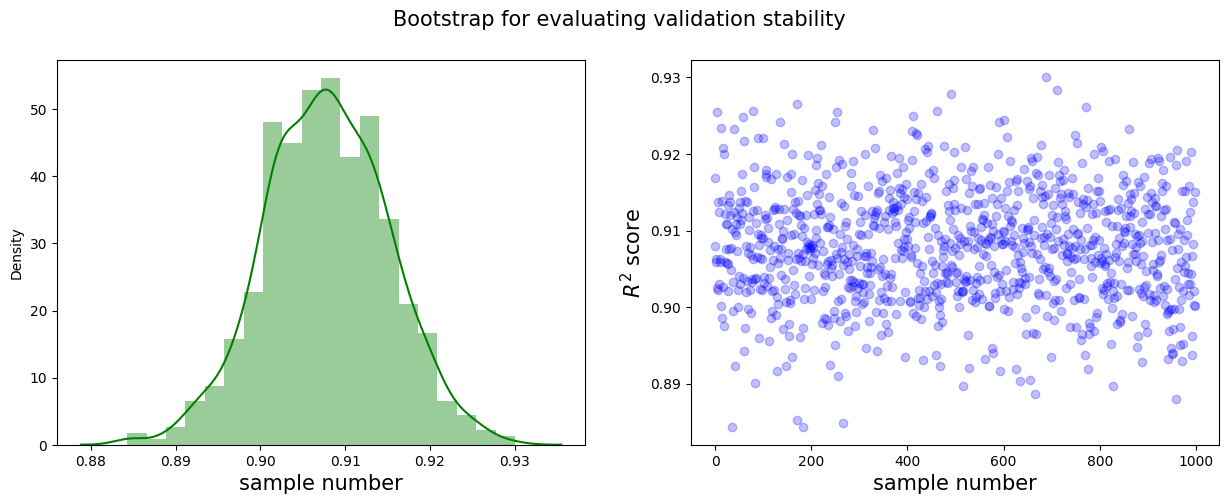

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

In [48]:
calculate_confidence_interval(scores)

(0.8932272042801875, 0.9220566078980929)

In [49]:
0.9220566078980929 - 0.8932272042801875

0.028829403617905314

## Bagging как подход к построению композиций

Мы рассмотрели бутстреп, и теперь можем перейти к бэггингу, одну из самых простых способов построения композиции алгоритмов. Пусть имеется обучающая выборка $X$, с помощью бутстрепа сгенерируем выборки $X_1$, $X_2$, ..., $X_M$, и на каждой выборке обучим свой классификатор $a_i(X)$. Итоговый классификатор будет являться __усреднением__ прогнозов отдельных алгоритмов.

Параметры `BaggingClassifier`:
* `base_estimator` - базовый алгоритм для обучения;
* `n_estimators` - количество базовых алгоритмов;
* `max_samples` - доля объектов обучающей выборки для обучения базового алгоритма;
* `max_features` - доля признаков для обучения базового алгоритма;
* `bootstrap` - флаг использования бутстрепа.

## Bagging над линейными моделями

In [14]:
bagging = BaggingClassifier(
    base_estimator=pipeline, random_state=27, n_jobs=2
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    bagging, x_train, y_train, x_valid, y_valid
)

C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model Score: train = 0.6621, valid = 0.6627


In [15]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=bagging,
    param_range=[10, 25, 50, 100],
    param_name="n_estimators",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156:

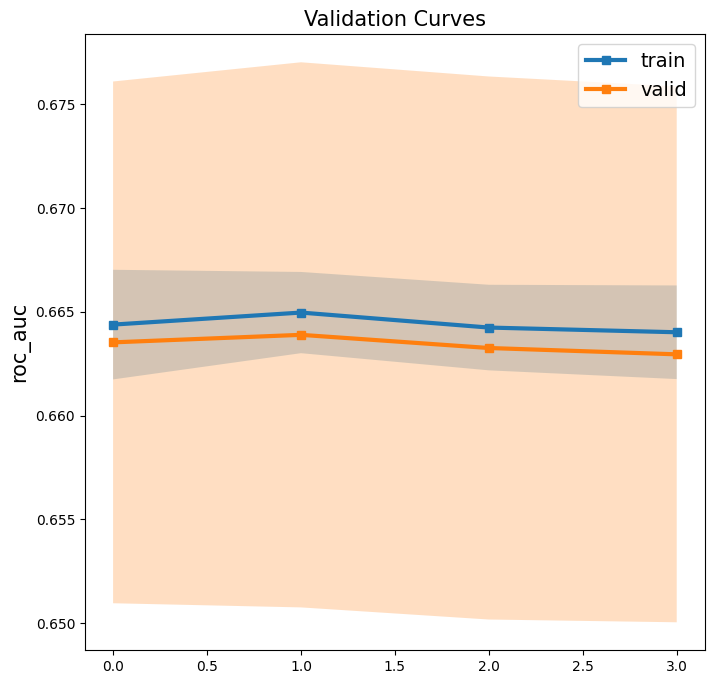

In [18]:
plot_validation_curves(
    train_scores, valid_scores
)

__ВЫВОД:__ при использовании линейной модели в качества базового алгоритма для бэггинга, не удалось добиться прироста качества. Это связано с тем, что смещение у линейных моделей большое, но дисперсия - очень маленькая. Линейные модели стабильно работают относительно разных выборок. Использование бэггинга для линейных моделей не позволяет значительно повысить качество.

## Bagging над решающими деревьями неограниченной глубины

In [19]:
bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=27), random_state=27, n_jobs=2
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    bagging, x_train, y_train, x_valid, y_valid
)

C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model Score: train = 0.9995, valid = 0.8676


## Bagging над решающими деревьями ограниченной глубины

In [20]:
%%time
bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5, random_state=27), random_state=27, n_jobs=2
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    bagging, x_train, y_train, x_valid, y_valid
)

C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model Score: train = 0.8155, valid = 0.8087
CPU times: total: 62.5 ms
Wall time: 1.11 s


In [21]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=bagging,
    param_range=[10, 25, 50, 100],
    param_name="n_estimators",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\КЫРГЫЗ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156:

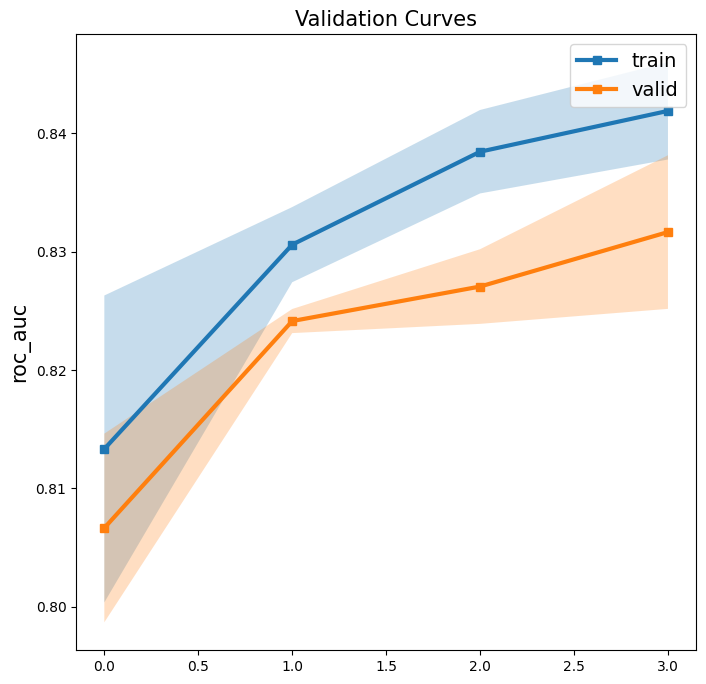

In [23]:
plot_validation_curves(
    train_scores, valid_scores
)

__ВЫВОД:__ при изменении решающего дерева, ограниченной глубины или неограниченной глубины, в качества базового алгоритма для бэггинга, удается добиться прироста качества, и сделать модель более стабильной. Это связано с тем, что смещение у деревье маленькое смещение, но очень больашя дисперсия. Мы видим проявление компромисса между смещением и разбросом, в полной мере. Использование бэггинга для линейных моделей позволяет значительно повысить качество, итоговое качество зависит от количества базовых алгоритмов. Чем сложнее базовый алгоритм - тем больше таких алгоритмов требуется для стабилизации модели. Этот эффект проявляется на примере использования деревьев с неограниченной глубиной.

## Случайный лес

In [127]:
forest = RandomForestClassifier(max_depth =14,
    random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    
    forest, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.9714, valid = 0.9078


In [128]:
np.random.seed(27)
scores = create_bootstrap_metrics(
    y_valid, y_valid_pred, roc_auc_score
)

C:\Users\КЫРГЫЗ\AppData\Local\Temp\ipykernel_8092\573118077.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores, ax=axes[0], color="green", bins=20)


Text(0.5, 0, 'sample number')

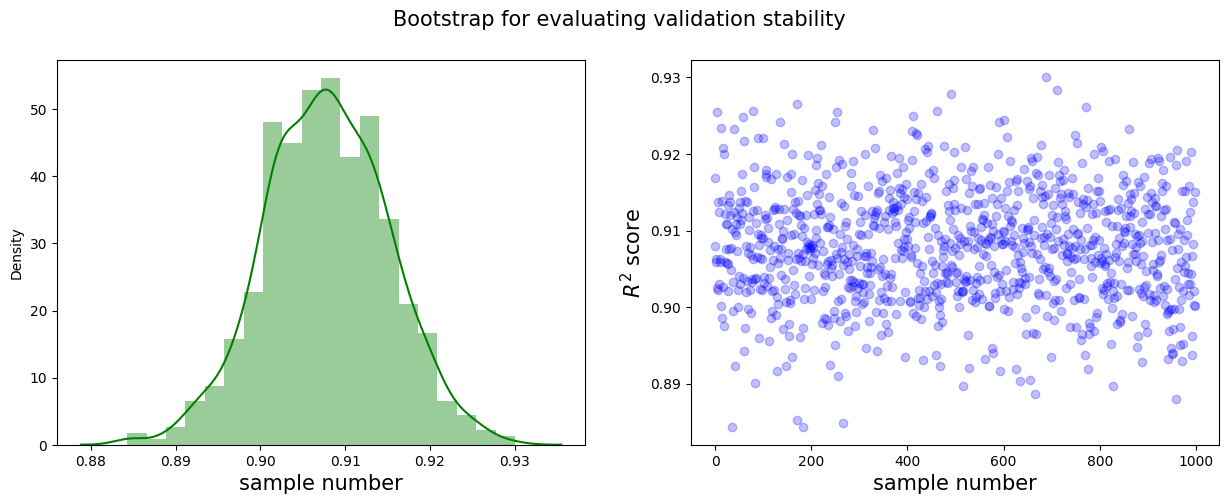

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

In [130]:
calculate_confidence_interval(scores)

(0.8932272042801875, 0.9220566078980929)

In [132]:
round(0.8932272042801875 - 0.9220566078980929,5)

-0.02883

In [24]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=forest,
    param_range=range(2, 15),
    param_name="max_depth",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

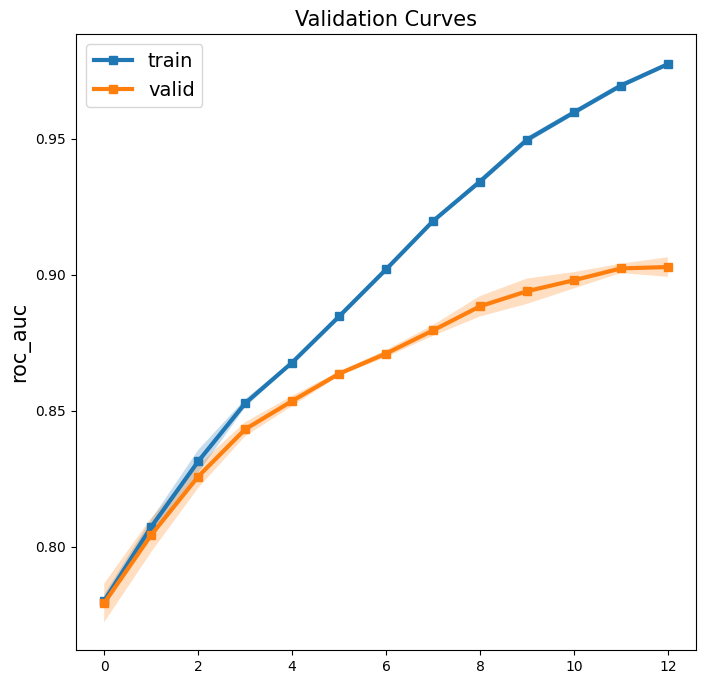

In [25]:
plot_validation_curves(
    train_scores, valid_scores
)

## Подбор числа деревьев одной моделью

In [28]:
forest = RandomForestClassifier(
    n_estimators=500, max_depth=12, random_state=27
)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [36]:
train_predictions = np.zeros(shape=(x_train.shape[0], forest.n_estimators))
valid_predictions = np.zeros(shape=(x_valid.shape[0], forest.n_estimators))

for num, tree in enumerate(forest.estimators_):
    train_predictions[:, num] = tree.predict_proba(x_train)[:, 1]
    valid_predictions[:, num] = tree.predict_proba(x_valid)[:, 1]

In [37]:
train_size = np.arange(1, train_predictions.shape[1]+1)
valid_size = np.arange(1, valid_predictions.shape[1]+1)

train_predictions = np.cumsum(train_predictions, axis=1) / train_size
valid_predictions = np.cumsum(valid_predictions, axis=1) / valid_size

In [38]:
train_scores = [
    roc_auc_score(y_train, train_predictions[:, num])
    for num in range(train_predictions.shape[1])
]
valid_scores = [
    roc_auc_score(y_valid, valid_predictions[:, num])
    for num in range(valid_predictions.shape[1])
]

(0, 500)

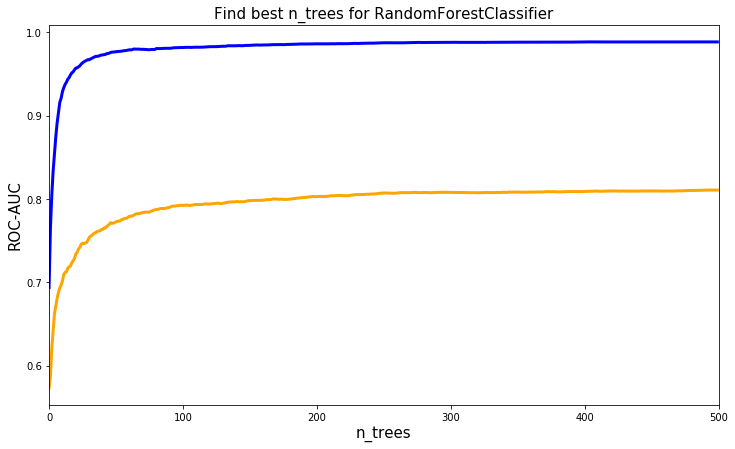

In [39]:
fig = plt.figure(figsize=(12, 7))

plt.title("Find best n_trees for RandomForestClassifier", size=15)
plt.plot(train_scores, linewidth=3, label="train-score", color="blue")
plt.plot(valid_scores, linewidth=3, label="valid-score", color="orange")
plt.xlabel("n_trees", size=15)
plt.ylabel("ROC-AUC", size=15)
plt.xlim(0, len(train_scores))